<a href="https://colab.research.google.com/github/ChiriKamau/notebooks/blob/main/edge_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start Karitho

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

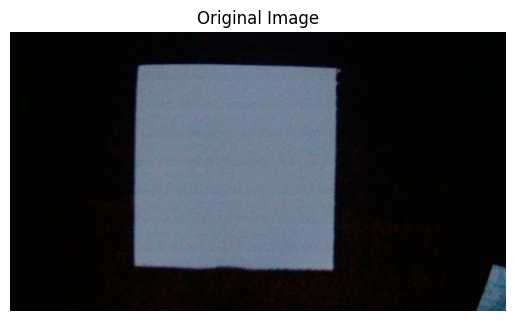

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Raw GitHub image URL
image_url = "https://raw.githubusercontent.com/ChiriKamau/notebooks/main/capture2.jpg"

# Read image from URL
image_data = cv2.imdecode(
    np.asarray(bytearray(__import__("urllib").request.urlopen(image_url).read()), dtype=np.uint8),
    cv2.IMREAD_COLOR
)

# Convert BGR → RGB for correct display
image_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

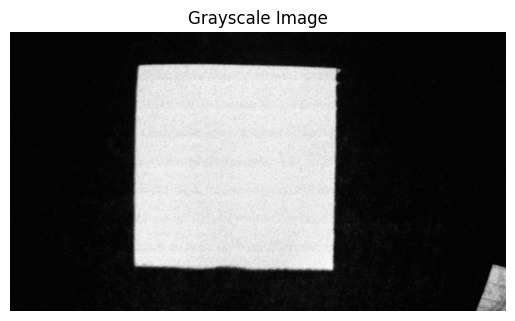

In [5]:
gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

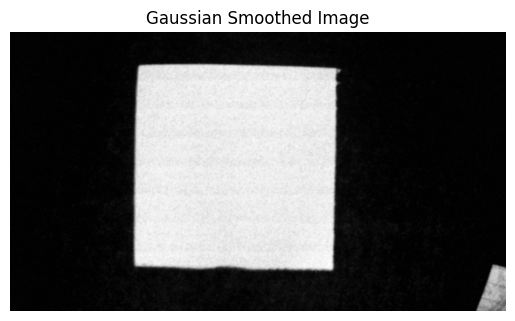

In [6]:
blur = cv2.GaussianBlur(gray, (5, 5), 1.0)

plt.imshow(blur, cmap="gray")
plt.title("Gaussian Smoothed Image")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

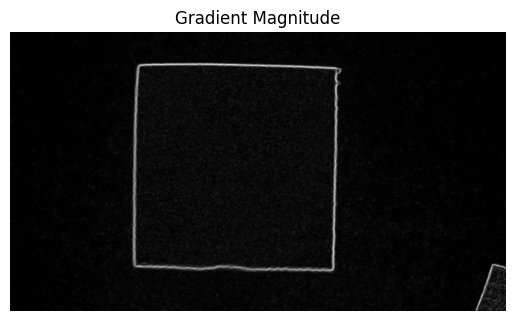

In [7]:
gx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = cv2.magnitude(gx, gy)
gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)

plt.imshow(gradient_magnitude, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

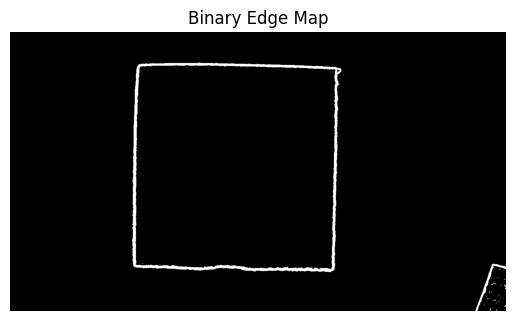

In [8]:
_, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

plt.imshow(edges, cmap="gray")
plt.title("Binary Edge Map")
plt.axis("off")


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

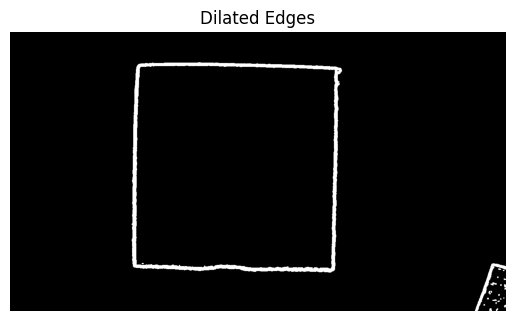

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges_dilated, cmap="gray")
plt.title("Dilated Edges")
plt.axis("off")


In [10]:
contours, _ = cv2.findContours(
    edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

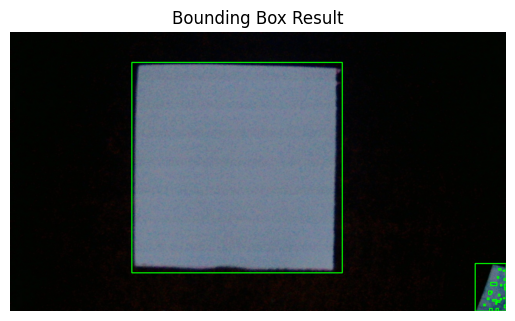

In [11]:
output = image_rgb.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(output)
plt.title("Bounding Box Result")
plt.axis("off")
